In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
f = np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_test = df_eddies[df_eddies.Day<=7011].copy()
df_test


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70874,1783,7011,CE,157.813103,-36.376450,245,111,830.728232,545.614363,-0.000020,-0.002834,-0.000900,-0.007137,76.500754,41.141020,147,2009-03-13,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.579934,340.645574
71013,1784,7008,AE,156.349771,-31.475145,189,206,549.557963,1016.479395,0.000010,0.002938,0.001482,0.001840,48.252890,-3.963317,37,2009-03-10,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
71014,1784,7009,AE,156.358761,-31.429262,189,207,548.862689,1021.588486,0.000010,0.002683,0.001706,0.002201,48.001598,-6.811978,37,2009-03-11,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
71015,1784,7010,AE,156.377090,-31.315021,189,209,546.762504,1034.176760,0.000010,0.002181,0.001247,0.002743,27.501120,-20.605021,37,2009-03-12,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [4]:
fnumber_old = 0
Bu = []
H = 1000
for k in range(len(df_test)):
    data = df_test.iloc[k]
    fname = data.fname
    fnumber = int(data.fname[-8:-3])
    if fnumber != fnumber_old:
        N2bar = np.load(f'/srv/scratch/z5297792/Climatology/N2s/N2bar_{fnumber:05}.npy')
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == data.Day)[0][0]
    
    Bu.append( ((N2bar[data.ic, data.jc, t_rel] * H) / (f[data.ic, data.jc] * data.Rc * 1000))**2 )
df_test['Bu'] = Bu


(0.0, 2.5e-17)

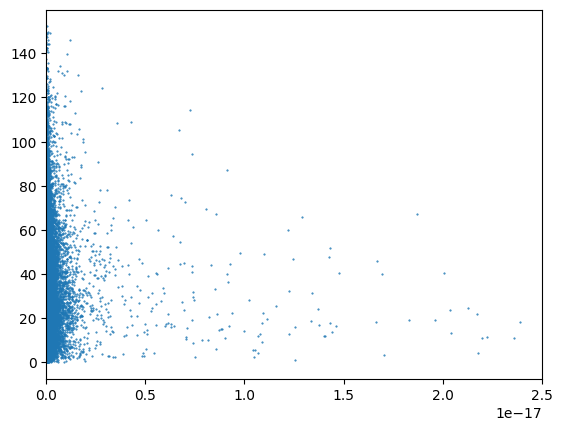

In [9]:
plt.scatter(df_test.Bu, df_test.TiltDis, marker='.', s=1)
plt.xlim(0, .25e-16)